In [3]:
import os
os.environ['NOTEBOOK_MODE'] = '1'
import sys
import torch as ch
from torch.distributions.multivariate_normal import MultivariateNormal
import numpy as np
import seaborn as sns
from scipy import stats
from tqdm import tqdm, tqdm_notebook
import matplotlib.pyplot as plt
from robustness import model_utils, datasets
from robustness.tools.vis_tools import show_image_row, show_image_column
from robustness.tools.label_maps import CLASS_DICT
%matplotlib inline

In [4]:
# Constants
DATA = 'CIFAR' # Choices: ['CIFAR', 'ImageNet', 'RestrictedImageNet']
BATCH_SIZE = 10
NUM_WORKERS = 8
NUM_CLASSES_VIS = 10

DATA_SHAPE = 32 if DATA == 'CIFAR' else 224 # Image size (fixed for dataset)
REPRESENTATION_SIZE = 2048 # Size of representation vector (fixed for model)
CLASSES = CLASS_DICT[DATA] # Class names for dataset
NUM_CLASSES = len(CLASSES) - 1 
NUM_CLASSES_VIS = min(NUM_CLASSES_VIS, NUM_CLASSES)
GRAIN = 4 if DATA != 'CIFAR' else 1

ORIGINAL_MODEL = True

In [5]:
# Load dataset
dataset_function = getattr(datasets, DATA)
dataset = dataset_function('./datasets/CIFAR10')
_, test_loader = dataset.make_loaders(workers=NUM_WORKERS, 
                                      batch_size=BATCH_SIZE, 
                                      data_aug=False)
data_iterator = enumerate(test_loader)

==> Preparing dataset cifar..
Files already downloaded and verified
Files already downloaded and verified


In [6]:
def downsample(x, step=GRAIN):
    down = ch.zeros([len(x), 3, DATA_SHAPE//step, DATA_SHAPE//step])

    for i in range(0, DATA_SHAPE, step):
        for j in range(0, DATA_SHAPE, step):
            v = x[:, :, i:i+step, j:j+step].mean(dim=2, keepdim=True).mean(dim=3, keepdim=True)
            ii, jj = i // step, j // step
            down[:, :, ii:ii+1, jj:jj+1] = v
    return down

def upsample(x, step=GRAIN):
    up = ch.zeros([len(x), 3, DATA_SHAPE, DATA_SHAPE])

    for i in range(0, DATA_SHAPE, step):
        for j in range(0, DATA_SHAPE, step):
            ii, jj = i // step, j // step
            up[:, :, i:i+step, j:j+step] = x[:, :, ii:ii+1, jj:jj+1]
    return up

In [7]:
# Get seed distribution (can be memory intensive to do all ImageNet classes at once)

im_test, targ_test = [], []
for _, (im, targ) in enumerate(test_loader):
    im_test.append(im)
    targ_test.append(targ)
im_test, targ_test = ch.cat(im_test), ch.cat(targ_test)

conditionals = []
for i in tqdm(range(NUM_CLASSES_VIS)):
    imc = im_test[targ_test == i]
    down_flat = downsample(imc).view(len(imc), -1)
    mean = down_flat.mean(dim=0)
    down_flat = down_flat - mean.unsqueeze(dim=0)
    cov = down_flat.t() @ down_flat / len(imc)
    dist = MultivariateNormal(mean, covariance_matrix=cov+1e-4*ch.eye(3 * DATA_SHAPE//GRAIN * DATA_SHAPE//GRAIN))
    conditionals.append(dist)

100%|██████████| 10/10 [00:02<00:00,  3.72it/s]


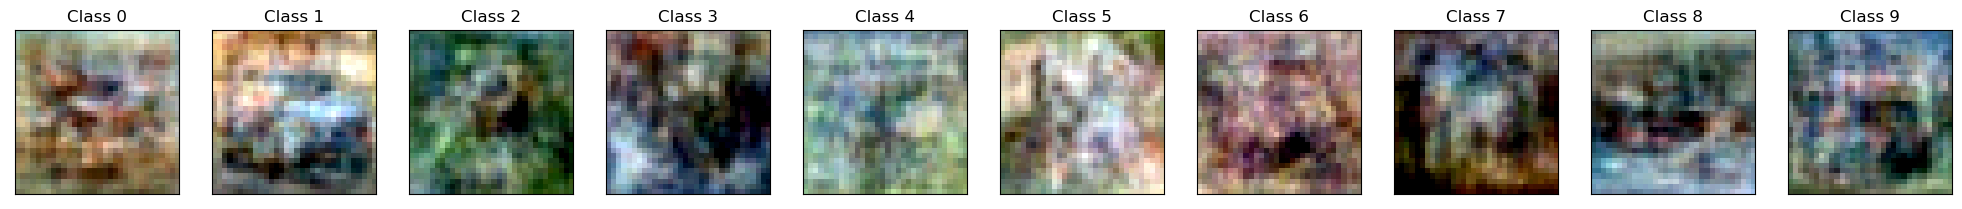

In [8]:
# Visualize seeds
img_seed = ch.stack([conditionals[i].sample().view(3, DATA_SHAPE//GRAIN, DATA_SHAPE//GRAIN) 
                     for i in range(NUM_CLASSES_VIS)])
img_seed = ch.clamp(img_seed, min=0, max=1)
show_image_row([img_seed.cpu()], tlist=[[f'Class {i}' for i in range(NUM_CLASSES_VIS)]])

In [9]:
# Load model
TRAINED_MODEL_PATH = './robust_models/trained_model_1.pt'

model_kwargs = {
    'arch': 'resnet50',
    'dataset': dataset,
    'resume_path': f'./robust_models/{DATA}_model.pt'
}

og_model, _ = model_utils.make_and_restore_model(**model_kwargs)

trained_model = ch.load(TRAINED_MODEL_PATH)

trained_model.eval()

=> loading checkpoint './robust_models/CIFAR_model.pt'
=> loaded checkpoint './robust_models/CIFAR_model.pt' (epoch 153)


AttackerModel(
  (normalizer): InputNormalize()
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): SequentialWithArgs(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential(
          (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(256, eps=1e-05, mo

In [10]:
def generation_loss(mod, inp, targ):
    op = mod(inp)
    loss = ch.nn.CrossEntropyLoss(reduction='none')(op, targ)
    return loss, None

def entropy(mod, inp, targ):
    op = mod(inp)
    loss = ch.nn.CrossEntropyLoss(reduction='none')(op, op)
    return loss, None

import math
kwargs = {
    'custom_loss': generation_loss,
    'constraint': '2',
    #'eps': math.inf,
    'eps': 30,
    'step_size': 0.5,
    'iterations': 30,
    'targeted': True
}

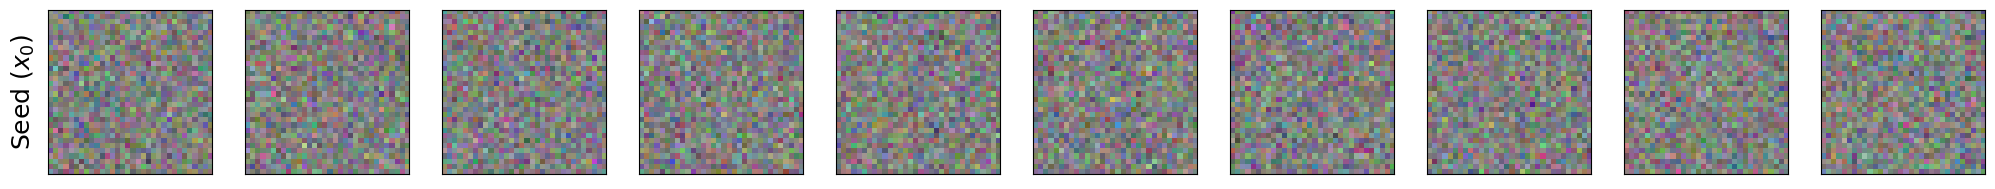

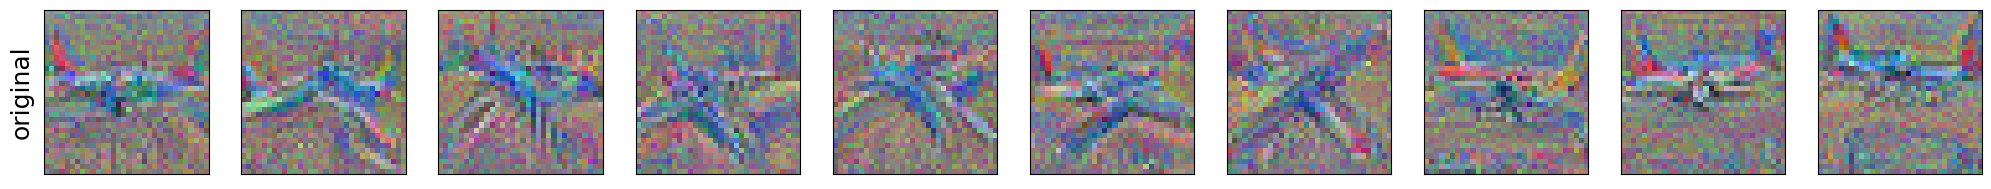

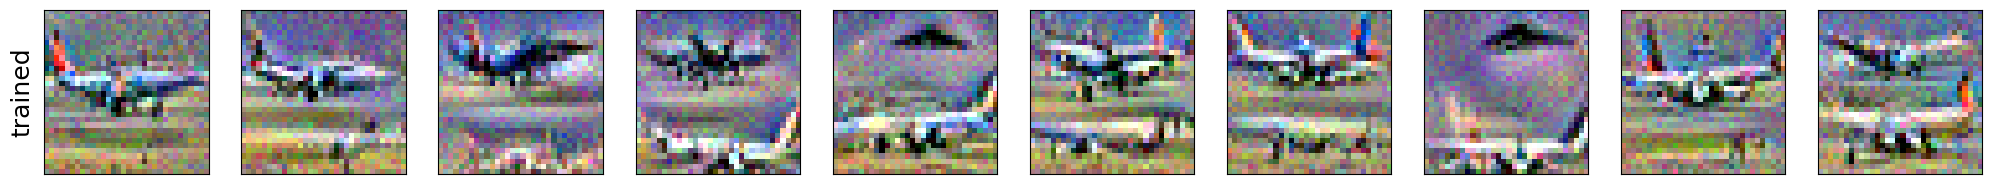

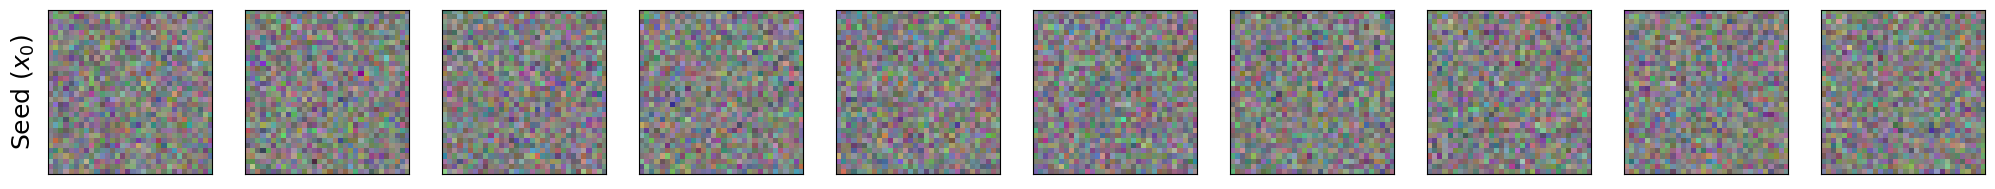

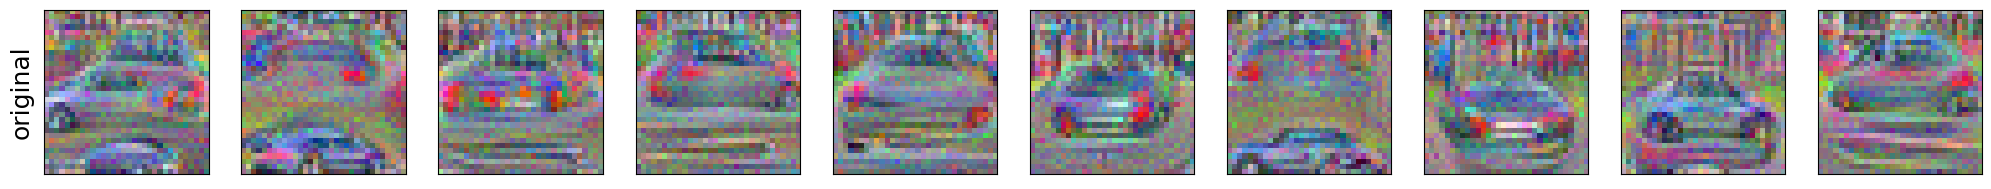

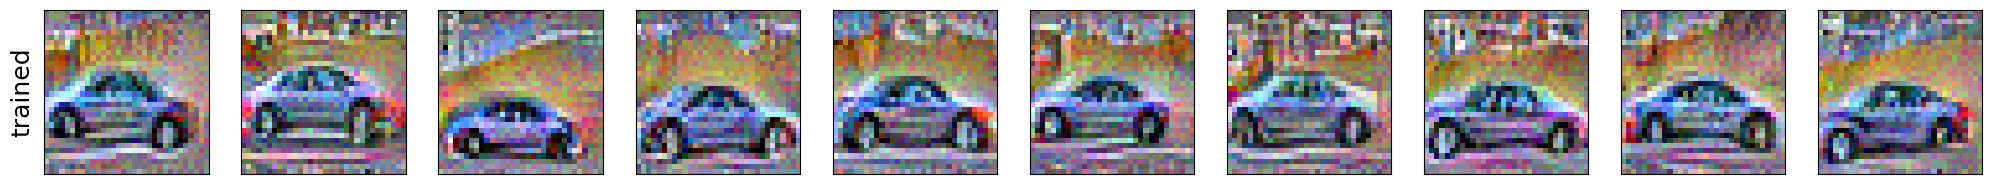

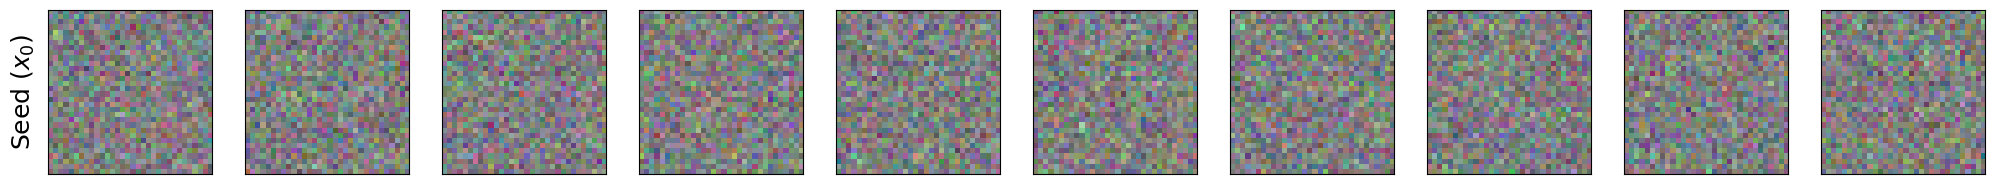

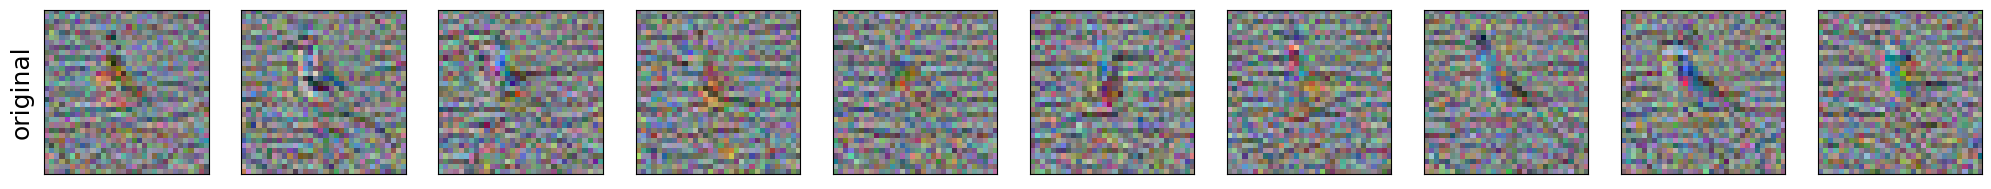

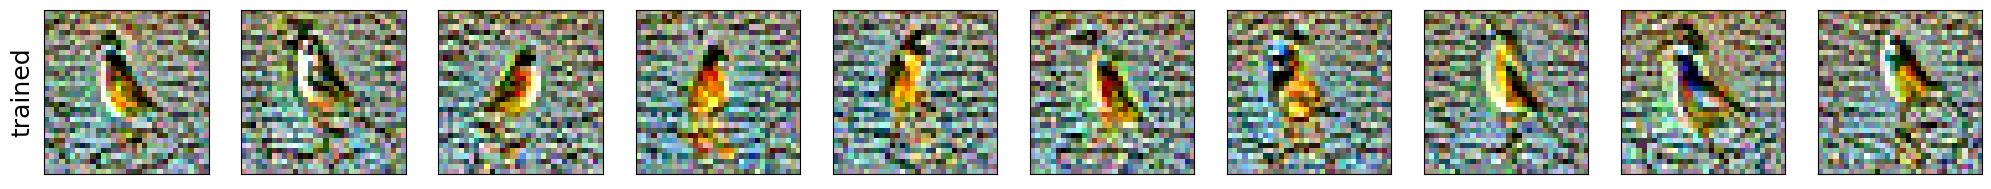

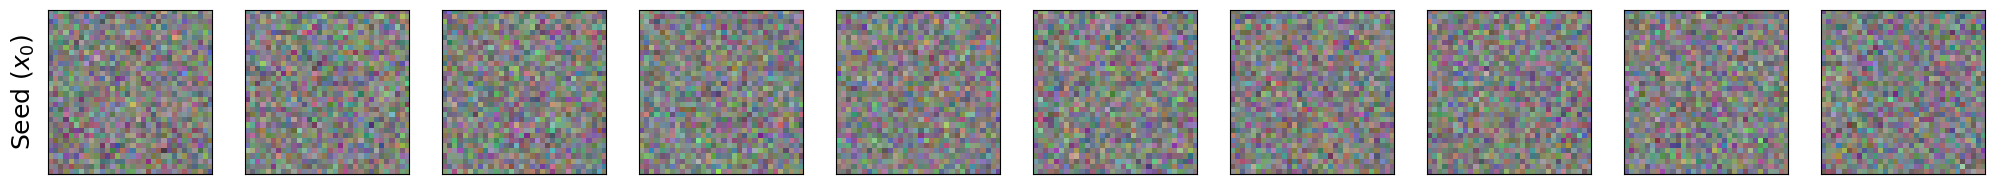

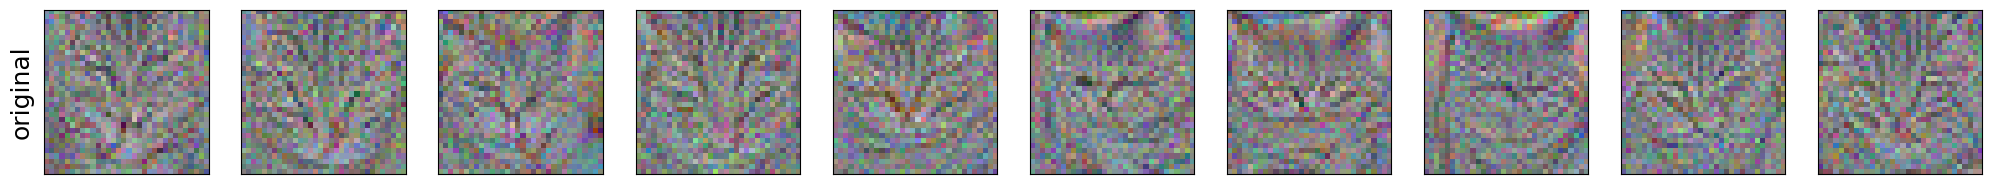

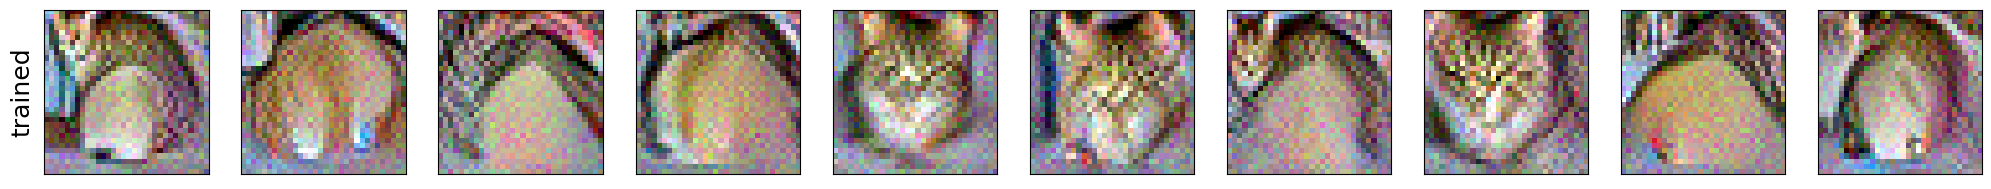

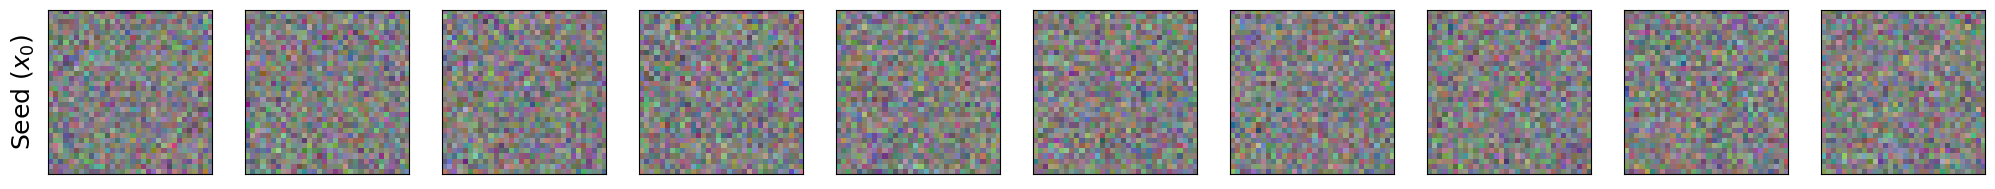

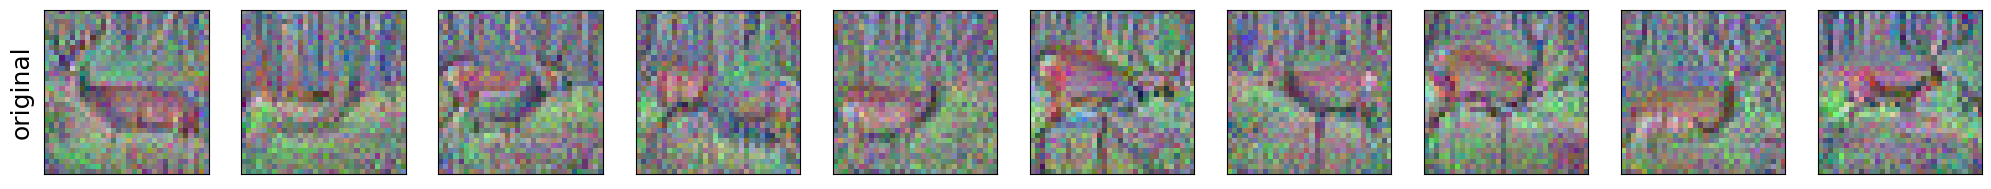

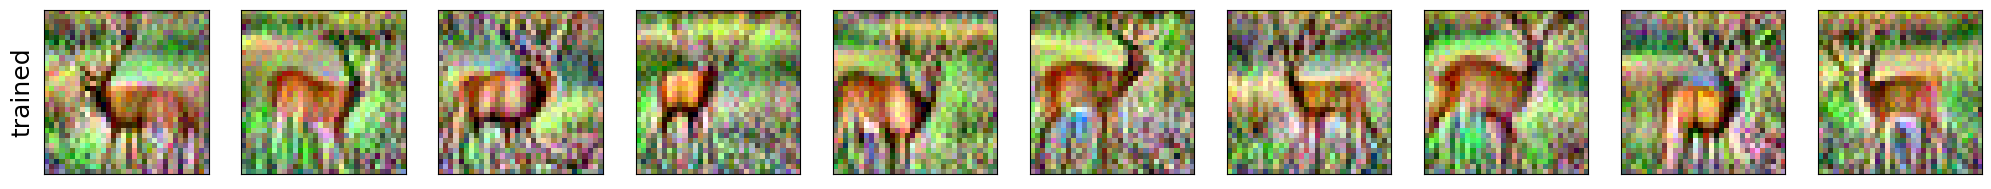

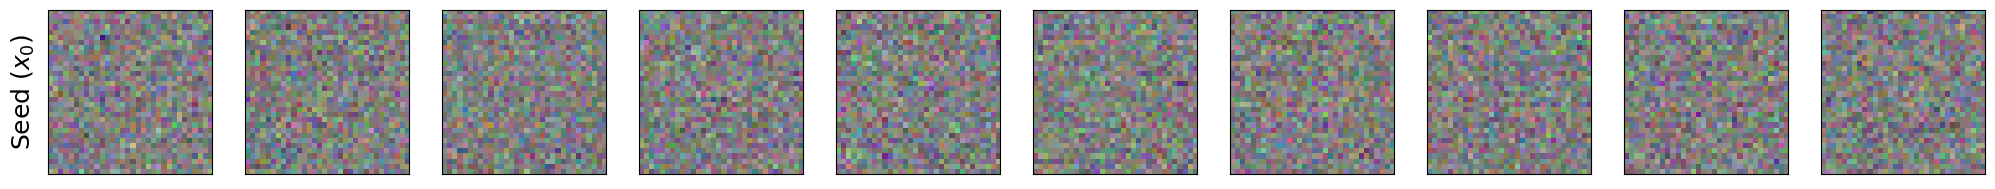

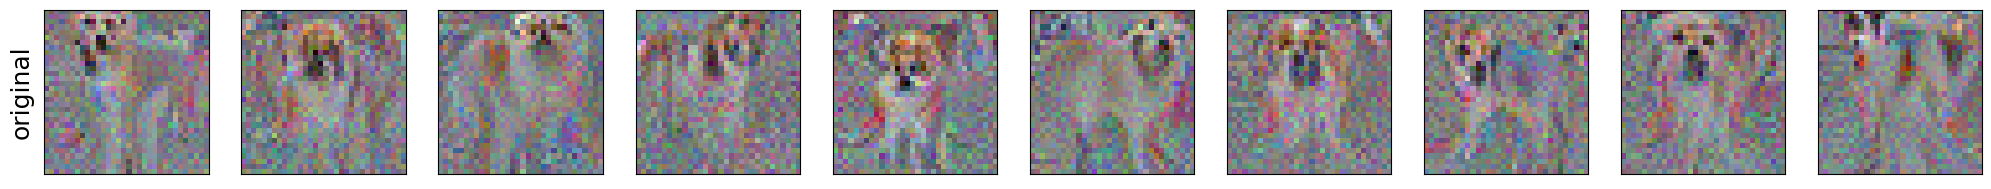

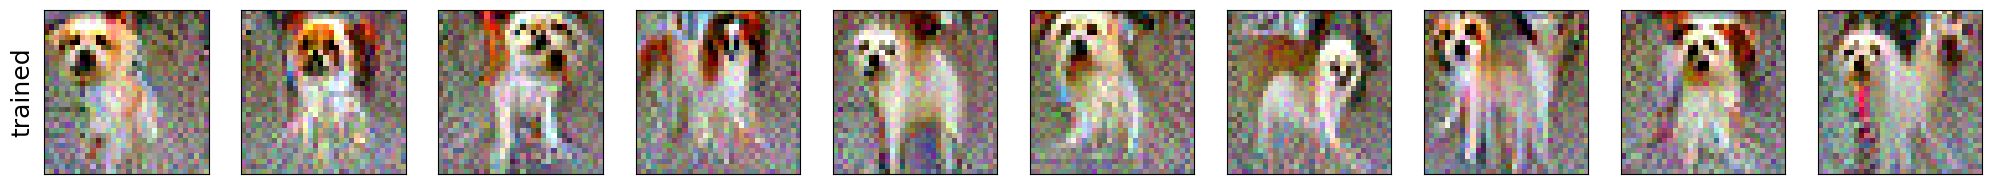

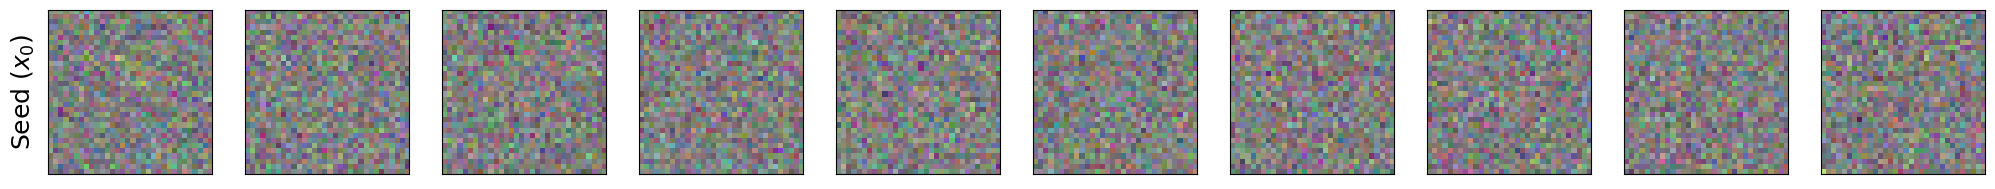

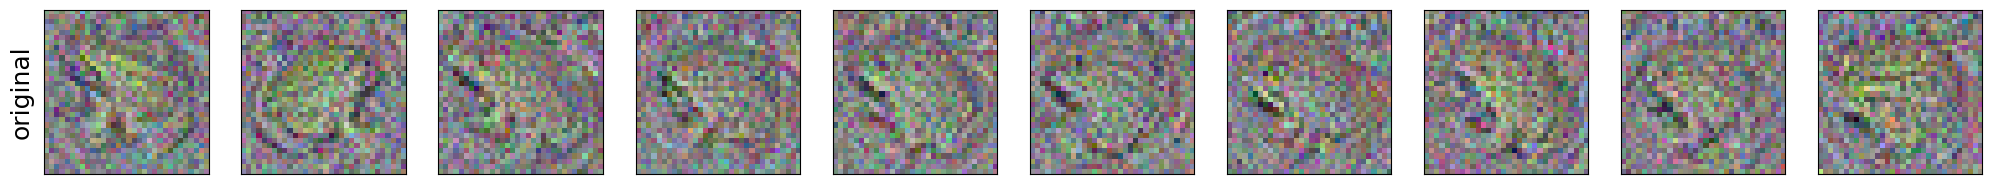

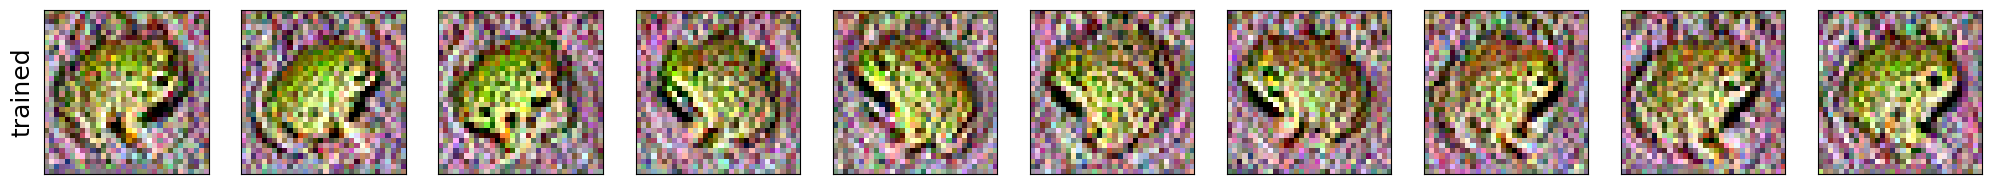

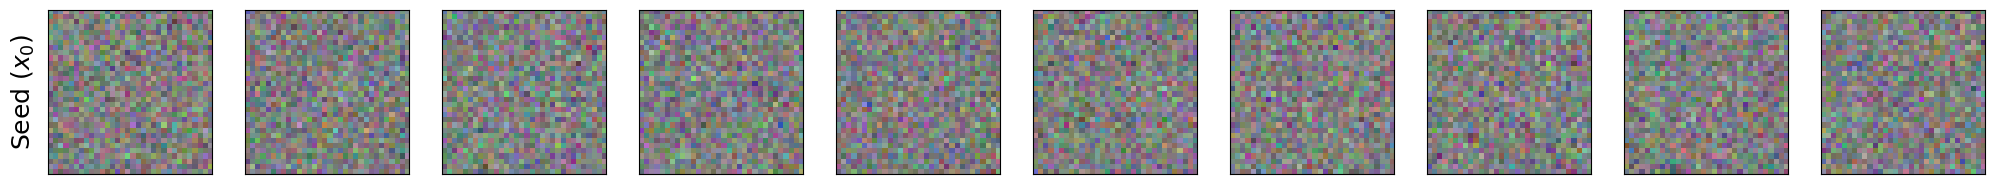

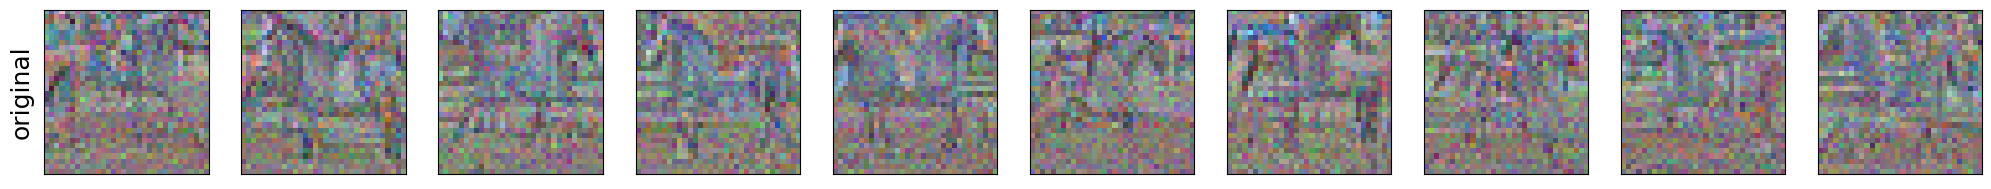

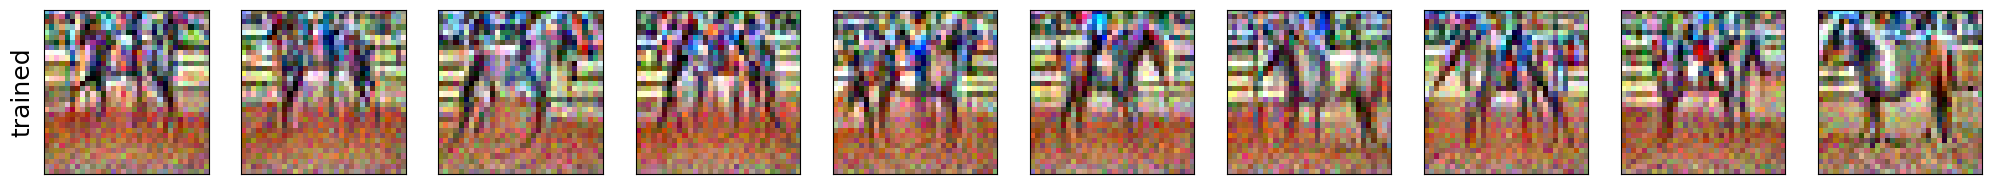

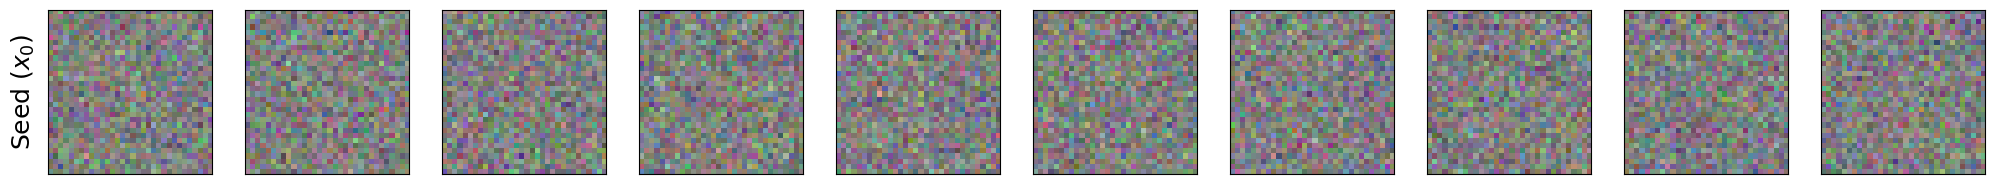

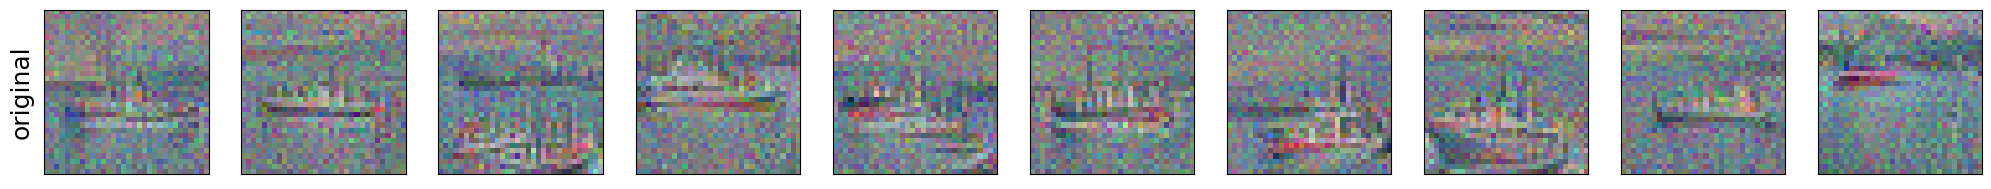

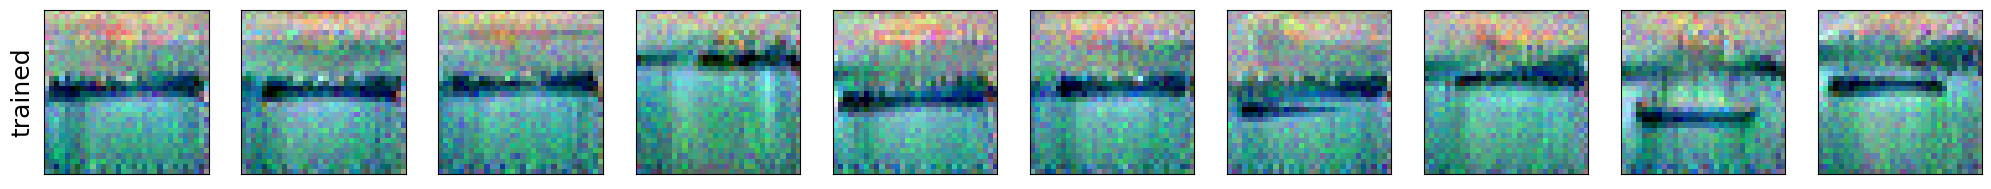

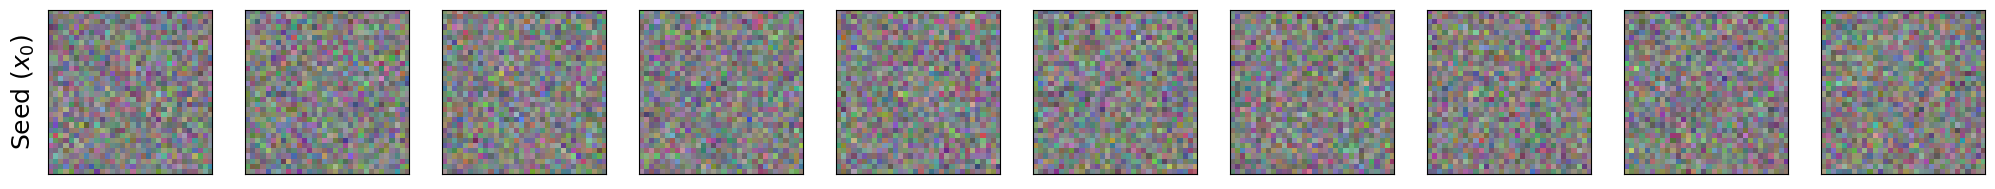

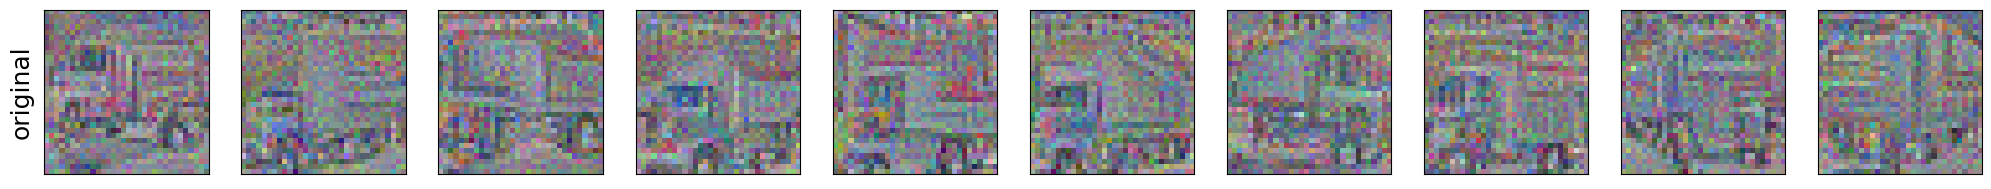

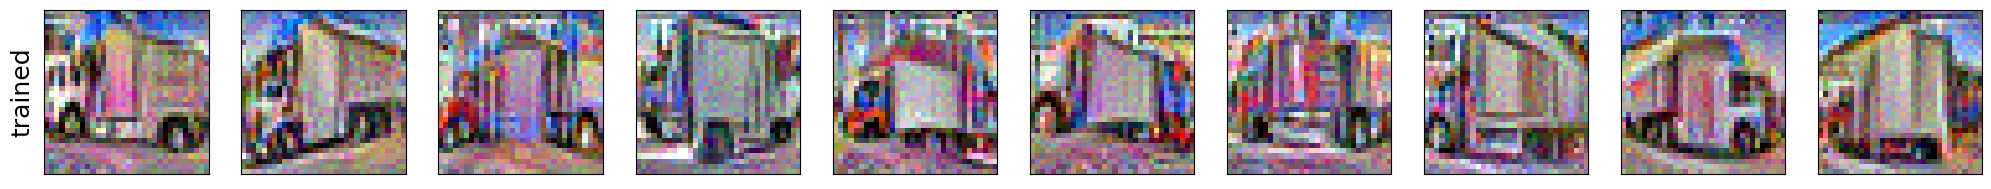

In [13]:
og_model.cuda()
trained_model.cuda()

show_seed = True
for i in range(NUM_CLASSES_VIS):
    target_class = i * ch.ones((BATCH_SIZE, )).to("cuda:0")
    

    #im_seed = ch.stack([conditionals[int(t)].sample().view(3, DATA_SHAPE//GRAIN, DATA_SHAPE//GRAIN) for t in target_class])
    im_seed = ch.stack([ch.randn(3, DATA_SHAPE//GRAIN, DATA_SHAPE//GRAIN) * 0.1 + 0.5 for t in target_class])    
    im_seed = upsample(ch.clamp(im_seed, min=0, max=1))
    #im_seed = upsample(im_seed)
    im_seed = im_seed.to("cuda:0")

    #print('im_seed:', im_seed.type(), im_seed.shape)

    #print(im_seed.device)

    #print('im_gen:', im_gen.type(), im_gen.shape)    
    _, og_im_gen = og_model(im_seed, target_class.long(), make_adv=True, **kwargs)
    og_im_gen = ch.clamp(og_im_gen, min=0, max=1)

    _, trained_im_gen = trained_model(im_seed, target_class.long(), make_adv=True, **kwargs)
    trained_im_gen = ch.clamp(trained_im_gen, min=0, max=1)


    if show_seed:
        show_image_row([ch.clamp(im_seed.to("cpu"), min=0, max=1)], [f'Seed ($x_0$)'], fontsize=18)
    show_image_row([og_im_gen.detach().to("cpu")], 
                   ['original'], 
                   fontsize=18)
    show_image_row([trained_im_gen.detach().to("cpu")], 
                   ['trained'], 
                   fontsize=18)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


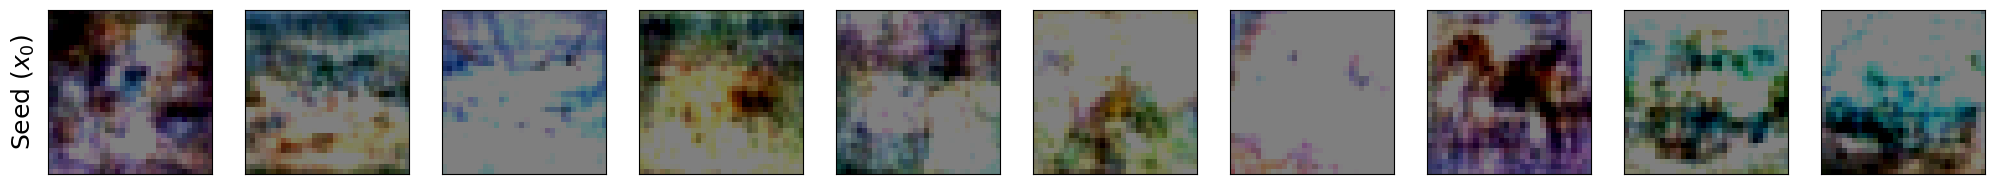

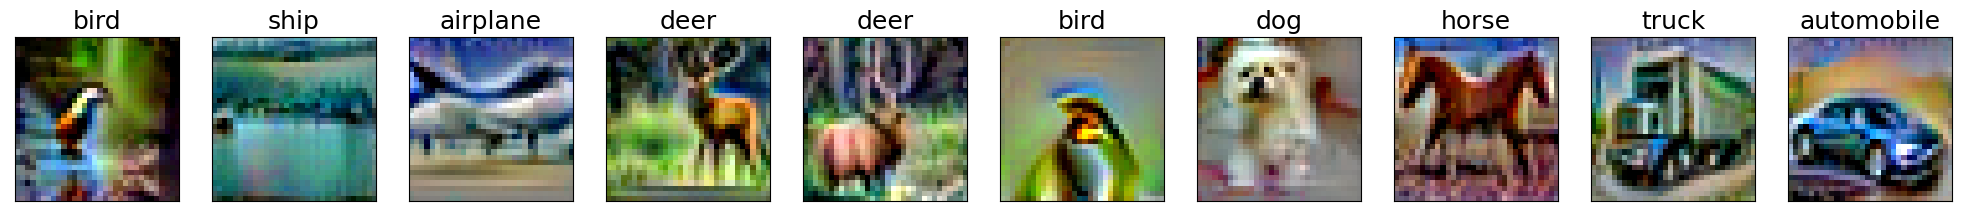

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


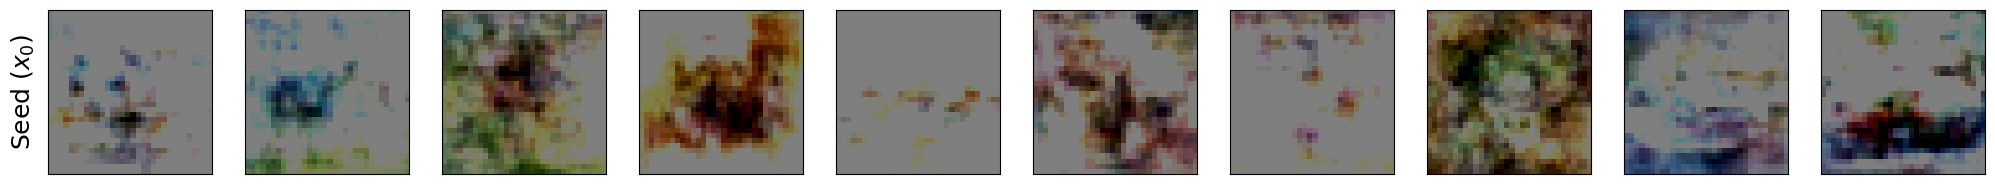

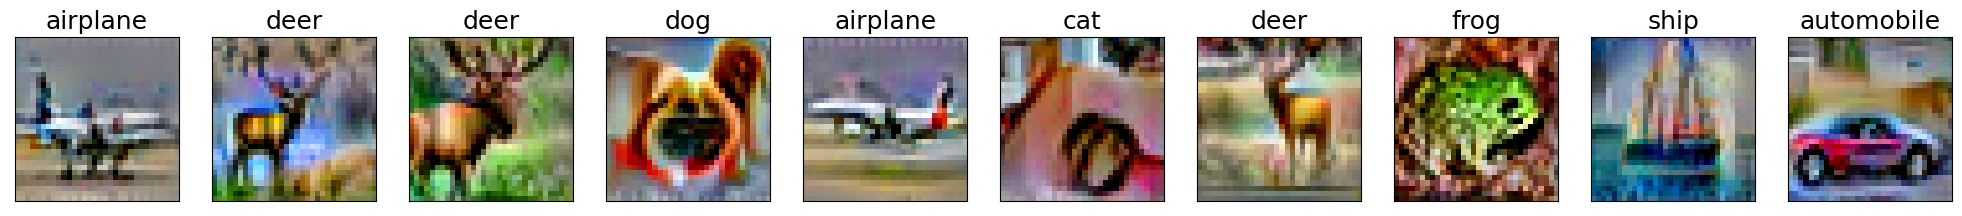

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


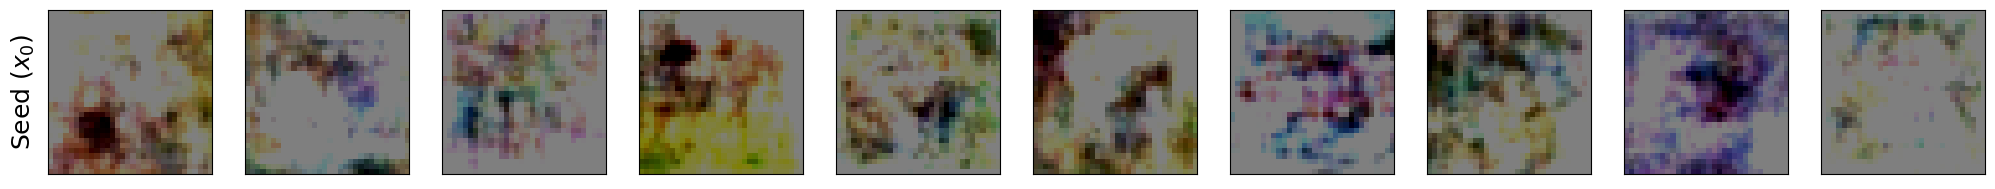

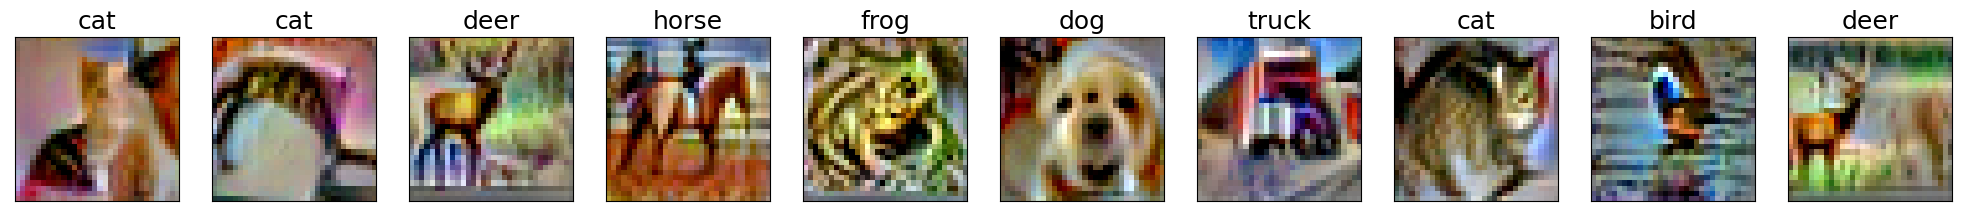

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


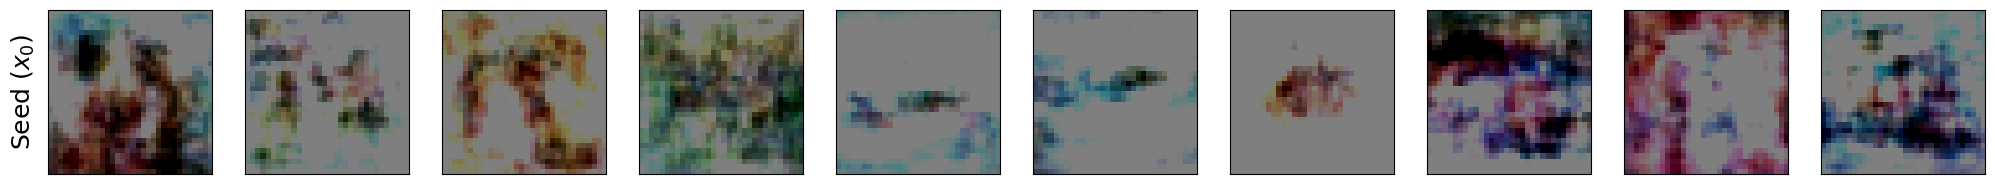

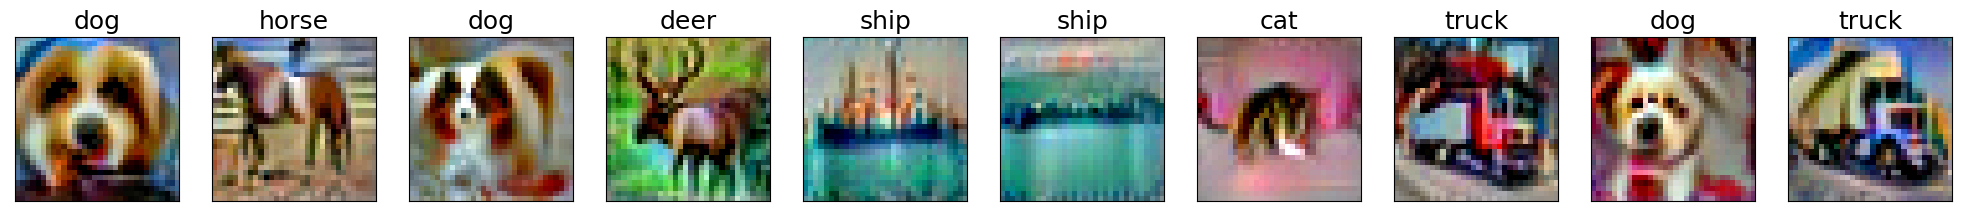

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


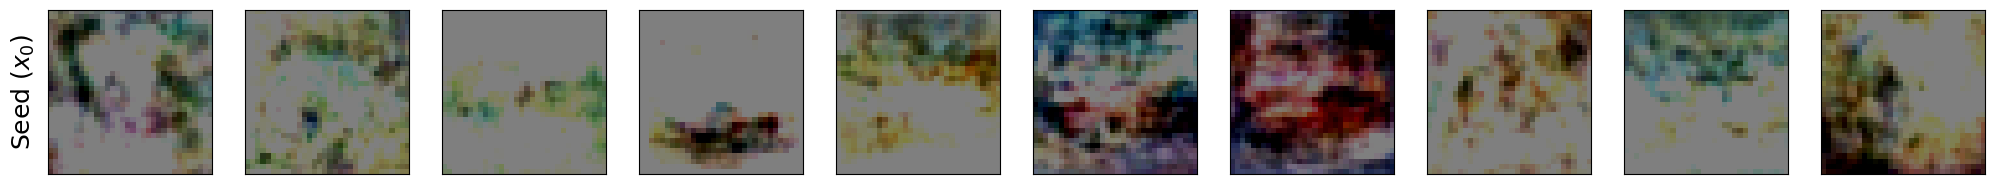

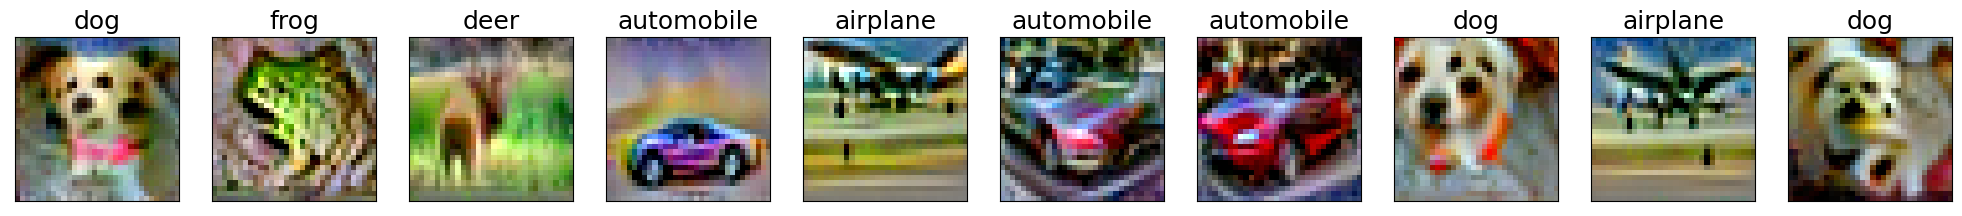

In [12]:
show_seed = True
for i in range(5):
    target_class = ch.tensor(np.random.choice(range(NUM_CLASSES_VIS), (BATCH_SIZE,)))
    target_class = target_class.to("cuda:0")

    im_seed = ch.stack([conditionals[int(t)].sample().view(3, DATA_SHAPE//GRAIN, DATA_SHAPE//GRAIN) 
                        for t in target_class])
    im_seed = upsample(ch.clamp(im_seed, min=-0.5, max=0.5))
    im_seed = im_seed.to("cuda:0")


    _, im_gen = trained_model(im_seed, target_class.long(), make_adv=True, **kwargs)
    if show_seed:
        show_image_row([im_seed.to("cpu")], [f'Seed ($x_0$)'], fontsize=18)
    show_image_row([im_gen.detach().to("cpu")], 
                   tlist=[[CLASSES[int(t)].split(',')[0] for t in target_class]], 
                   fontsize=18)